In [1]:

import os
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
from tqdm.auto import tqdm                  

%matplotlib inline

print("Libraries imported successfully.")


Libraries imported successfully.


In [2]:
from google.colab import drive
drive.mount('/content/drive')


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
import zipfile, os

zip_path = '/content/drive/MyDrive/animal_dataset.zip'                                

with zipfile.ZipFile(zip_path, 'r') as zf:
    zf.extractall('/content/animal_dataset')                                      

print("Zip extracted. Directory contents:")
print(os.listdir('/content/animal_dataset'))


Zip extracted. Directory contents:
['panda', 'animal_dataset', 'dog', 'cat']


In [4]:
import os
print(os.listdir('/content/drive/MyDrive'))


['animal_dataset.zip', 'Colab Notebooks', 'AIUB', 'image', 'Exhibition ', 'Presentation ', 'Club-Activity-Application-Form_230605_145854_230619_103916.pdf', 'Gpt', 'Banner for table.jpg', 'X_Banner (1).pdf', 'L_Banner (2).pdf', 'L_Banner (2).ai', 'X_Banner.pdf', 'L_Banner (1).pdf', 'L_Banner (1).ai', 'X_Banner.svg', 'X banner.pdf', 'L_Banner.pdf', 'L_Banner.ai', 'X banner.svg', '2. APPLICATION_Intra-AIUB Art Exhibition_2024_AAC (1).docx', 'Call for Application: AIUB Arts Club Executive Committee (Responses).gsheet', 'Saved from Chrome', 'Photography', 'Call for Application: AIUB Arts Club Executive Committee.gform', 'Certificate For Pint (1).zip', 'Certificate For Pint.zip', 'Untitled document.gdoc', 'DS']


In [5]:

DATASET_DIR = "animal_dataset"
IMAGE_SIZE = (32, 32)                 

def load_dataset(root_dir, image_size=(32, 32)):

    X = []
    y = []
    label_map = {}

                                                                
    class_folders = [
        d for d in sorted(os.listdir(root_dir))
        if os.path.isdir(os.path.join(root_dir, d))
    ]

    for label, class_name in enumerate(class_folders):
        class_dir = os.path.join(root_dir, class_name)
        label_map[label] = class_name

                                       
        img_files = [
            fname for fname in os.listdir(class_dir)
            if fname.lower().endswith(('.jpg', '.jpeg', '.png', '.bmp'))
        ]

                                          
        for fname in tqdm(img_files, desc=f"Loading {class_name}", ncols=80):
            img_path = os.path.join(class_dir, fname)

                                               
            img = Image.open(img_path).convert('L')

                                
            img = img.resize(image_size)

                                                         
            img_np = np.array(img, dtype=np.float32) / 255.0

                                                
            img_flat = img_np.flatten()

                      
            X.append(img_flat)
            y.append(label)

    X = np.array(X)
    y = np.array(y)

    print(f"Dataset Loaded: {X.shape} {y.shape}")
    return X, y, label_map


X, y, label_map = load_dataset(DATASET_DIR, IMAGE_SIZE)


Loading animal_dataset: 0it [00:00, ?it/s]

Loading cat:   0%|                                      | 0/100 [00:00<?, ?it/s]

Loading dog:   0%|                                      | 0/100 [00:00<?, ?it/s]

Loading panda:   0%|                                    | 0/100 [00:00<?, ?it/s]

Dataset Loaded: (300, 1024) (300,)


In [6]:

unique_labels, counts = np.unique(y, return_counts=True)
print("Class distribution:")
for lbl, cnt in zip(unique_labels, counts):
    print(f"  Label {lbl} ({label_map[lbl]}): {cnt} samples")

print("\nTotal samples:", len(y))


Class distribution:
  Label 1 (cat): 100 samples
  Label 2 (dog): 100 samples
  Label 3 (panda): 100 samples

Total samples: 300


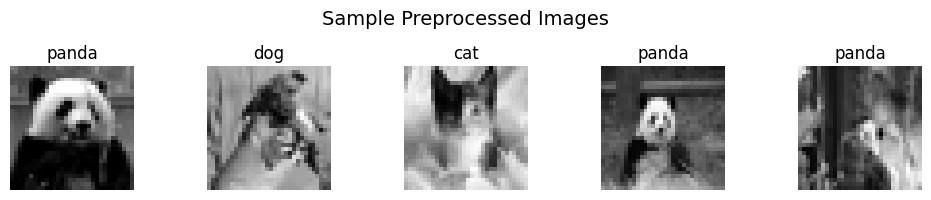

In [7]:
np.random.seed(0)
idxs = np.random.choice(len(X), size=5, replace=False)

plt.figure(figsize=(10, 2))
for i, idx in enumerate(idxs):
    plt.subplot(1, 5, i+1)
    plt.imshow(X[idx].reshape(IMAGE_SIZE), cmap='gray')
    plt.title(label_map[y[idx]])
    plt.axis('off')
plt.suptitle("Sample Preprocessed Images", fontsize=14)
plt.tight_layout()
plt.show()


In [8]:

def l1_distance(x, X_train):

    return np.sum(np.abs(X_train - x), axis=1)


def l2_distance(x, X_train):

    return np.sqrt(np.sum((X_train - x) ** 2, axis=1))


In [9]:

np.random.seed(1)
idx_a, idx_b = np.random.choice(len(X), size=2, replace=False)

x_a = X[idx_a]
x_b = X[idx_b]

l1_ab = l1_distance(x_a, X[[idx_b]])[0]
l2_ab = l2_distance(x_a, X[[idx_b]])[0]

print(f"Comparing sample {idx_a} (label={label_map[y[idx_a]]}) "
      f"and sample {idx_b} (label={label_map[y[idx_b]]}):")
print(f"  L1 distance = {l1_ab:.6f}")
print(f"  L2 distance = {l2_ab:.6f}")


Comparing sample 189 (label=dog) and sample 123 (label=dog):
  L1 distance = 257.431396
  L2 distance = 9.547193


In [10]:

def knn_predict(X_train, y_train, X_test, k=3, distance_type='l2'):


    y_pred = []

    for i in range(X_test.shape[0]):
        x = X_test[i]

                   
        if distance_type == 'l1':
            dists = l1_distance(x, X_train)
        elif distance_type == 'l2':
            dists = l2_distance(x, X_train)
        else:
            raise ValueError("distance_type must be 'l1' or 'l2'")

                                        
        nn_indices = np.argsort(dists)[:k]

                                     
        nn_labels = y_train[nn_indices]

                       
        values, counts = np.unique(nn_labels, return_counts=True)
        majority_label = values[np.argmax(counts)]
        y_pred.append(majority_label)

    return np.array(y_pred)


In [11]:

def knn_predict_weighted(X_train, y_train, X_test, k=3, distance_type='l2'):

    eps = 1e-8
    y_pred = []

    for i in range(X_test.shape[0]):
        x = X_test[i]

        if distance_type == 'l1':
            dists = l1_distance(x, X_train)
        elif distance_type == 'l2':
            dists = l2_distance(x, X_train)
        else:
            raise ValueError("distance_type must be 'l1' or 'l2'")

        nn_indices = np.argsort(dists)[:k]
        nn_dists   = dists[nn_indices]
        nn_labels  = y_train[nn_indices]

        weights = 1.0 / (nn_dists + eps)

        class_scores = {}
        for label, w in zip(nn_labels, weights):
            class_scores[label] = class_scores.get(label, 0.0) + w

        best_label = max(class_scores.items(), key=lambda kv: kv[1])[0]
        y_pred.append(best_label)

    return np.array(y_pred)


In [12]:

def k_fold_indices(n_samples, k_folds=5, seed=42):
    np.random.seed(seed)
    indices = np.random.permutation(n_samples)

    fold_sizes = np.full(k_folds, n_samples // k_folds, dtype=int)
    fold_sizes[:n_samples % k_folds] += 1

    folds = []
    current = 0
    for fold_size in fold_sizes:
        start, stop = current, current + fold_size
        folds.append(indices[start:stop])
        current = stop

    return folds


def accuracy_score(y_true, y_pred):
    return np.mean(y_true == y_pred)


In [13]:

n_samples = X.shape[0]
k_folds = 5
folds = k_fold_indices(n_samples, k_folds)

                                  
K_values = list(range(1, 31, 2))
distance_types = ['l1', 'l2']

                                           
results = {
    dist: np.zeros((len(K_values), k_folds))
    for dist in distance_types
}

for dist_type in distance_types:
    print(f"\n=== Distance metric: {dist_type.upper()} ===")
    for k_idx, k in enumerate(K_values):
        for fold_idx in range(k_folds):
            val_idx = folds[fold_idx]
            train_idx = np.concatenate([folds[i] for i in range(k_folds) if i != fold_idx])

            X_train, y_train = X[train_idx], y[train_idx]
            X_val,   y_val   = X[val_idx],   y[val_idx]

            y_val_pred = knn_predict(X_train, y_train, X_val,
                                     k=k, distance_type=dist_type)
            acc = accuracy_score(y_val, y_val_pred)
            results[dist_type][k_idx, fold_idx] = acc

            print(f"Fold {fold_idx + 1}/{k_folds}, K={k}: Accuracy={acc:.4f}")



=== Distance metric: L1 ===
Fold 1/5, K=1: Accuracy=0.3333
Fold 2/5, K=1: Accuracy=0.4167
Fold 3/5, K=1: Accuracy=0.3500
Fold 4/5, K=1: Accuracy=0.4000
Fold 5/5, K=1: Accuracy=0.4333
Fold 1/5, K=3: Accuracy=0.2667
Fold 2/5, K=3: Accuracy=0.4667
Fold 3/5, K=3: Accuracy=0.2833
Fold 4/5, K=3: Accuracy=0.4167
Fold 5/5, K=3: Accuracy=0.3500
Fold 1/5, K=5: Accuracy=0.3500
Fold 2/5, K=5: Accuracy=0.5667
Fold 3/5, K=5: Accuracy=0.3833
Fold 4/5, K=5: Accuracy=0.3833
Fold 5/5, K=5: Accuracy=0.3833
Fold 1/5, K=7: Accuracy=0.4333
Fold 2/5, K=7: Accuracy=0.5500
Fold 3/5, K=7: Accuracy=0.4500
Fold 4/5, K=7: Accuracy=0.3833
Fold 5/5, K=7: Accuracy=0.3167
Fold 1/5, K=9: Accuracy=0.4333
Fold 2/5, K=9: Accuracy=0.5500
Fold 3/5, K=9: Accuracy=0.5000
Fold 4/5, K=9: Accuracy=0.3833
Fold 5/5, K=9: Accuracy=0.3167
Fold 1/5, K=11: Accuracy=0.4000
Fold 2/5, K=11: Accuracy=0.5333
Fold 3/5, K=11: Accuracy=0.4833
Fold 4/5, K=11: Accuracy=0.3833
Fold 5/5, K=11: Accuracy=0.3500
Fold 1/5, K=13: Accuracy=0.4000
Fold

In [14]:

print("Summary of 5-fold cross-validation (mean ± std):\n")

for dist_type in distance_types:
    mean_acc = results[dist_type].mean(axis=1)
    std_acc  = results[dist_type].std(axis=1)

    print(f"Distance: {dist_type.upper()}")
    for k, m, s in zip(K_values, mean_acc, std_acc):
        print(f"  K={k:2d}  ->  Accuracy = {m:.4f} ± {s:.4f}")
    print()


Summary of 5-fold cross-validation (mean ± std):

Distance: L1
  K= 1  ->  Accuracy = 0.3867 ± 0.0386
  K= 3  ->  Accuracy = 0.3567 ± 0.0764
  K= 5  ->  Accuracy = 0.4133 ± 0.0777
  K= 7  ->  Accuracy = 0.4267 ± 0.0772
  K= 9  ->  Accuracy = 0.4367 ± 0.0826
  K=11  ->  Accuracy = 0.4300 ± 0.0678
  K=13  ->  Accuracy = 0.4300 ± 0.0371
  K=15  ->  Accuracy = 0.4300 ± 0.0340
  K=17  ->  Accuracy = 0.4167 ± 0.0624
  K=19  ->  Accuracy = 0.4400 ± 0.0688
  K=21  ->  Accuracy = 0.4467 ± 0.0552
  K=23  ->  Accuracy = 0.4433 ± 0.0646
  K=25  ->  Accuracy = 0.4600 ± 0.0772
  K=27  ->  Accuracy = 0.4467 ± 0.0915
  K=29  ->  Accuracy = 0.4600 ± 0.1167

Distance: L2
  K= 1  ->  Accuracy = 0.3667 ± 0.0506
  K= 3  ->  Accuracy = 0.3500 ± 0.0624
  K= 5  ->  Accuracy = 0.3733 ± 0.0523
  K= 7  ->  Accuracy = 0.4067 ± 0.0429
  K= 9  ->  Accuracy = 0.4200 ± 0.0464
  K=11  ->  Accuracy = 0.4000 ± 0.0650
  K=13  ->  Accuracy = 0.4100 ± 0.0455
  K=15  ->  Accuracy = 0.4200 ± 0.0572
  K=17  ->  Accuracy = 0.4

In [15]:

mean_acc_l1 = results['l1'].mean(axis=1)
std_acc_l1  = results['l1'].std(axis=1)

mean_acc_l2 = results['l2'].mean(axis=1)
std_acc_l2  = results['l2'].std(axis=1)

print("K values:", K_values)
print("L1 mean accuracies:", np.round(mean_acc_l1, 4))
print("L2 mean accuracies:", np.round(mean_acc_l2, 4))

best_dist = None
best_k = None
best_acc = -1.0

for dist_type in distance_types:
    mean_acc = mean_acc_l1 if dist_type == 'l1' else mean_acc_l2
    for k_idx, k in enumerate(K_values):
        if mean_acc[k_idx] > best_acc:
            best_acc  = mean_acc[k_idx]
            best_dist = dist_type
            best_k    = k

print("\nBest configuration based on mean CV accuracy:")
print(f"  Distance metric: {best_dist.upper()}")
print(f"  K: {best_k}")
print(f"  Mean CV accuracy: {best_acc:.4f}")


K values: [1, 3, 5, 7, 9, 11, 13, 15, 17, 19, 21, 23, 25, 27, 29]
L1 mean accuracies: [0.3867 0.3567 0.4133 0.4267 0.4367 0.43   0.43   0.43   0.4167 0.44
 0.4467 0.4433 0.46   0.4467 0.46  ]
L2 mean accuracies: [0.3667 0.35   0.3733 0.4067 0.42   0.4    0.41   0.42   0.4433 0.4167
 0.4067 0.4167 0.4233 0.4233 0.4   ]

Best configuration based on mean CV accuracy:
  Distance metric: L1
  K: 29
  Mean CV accuracy: 0.4600


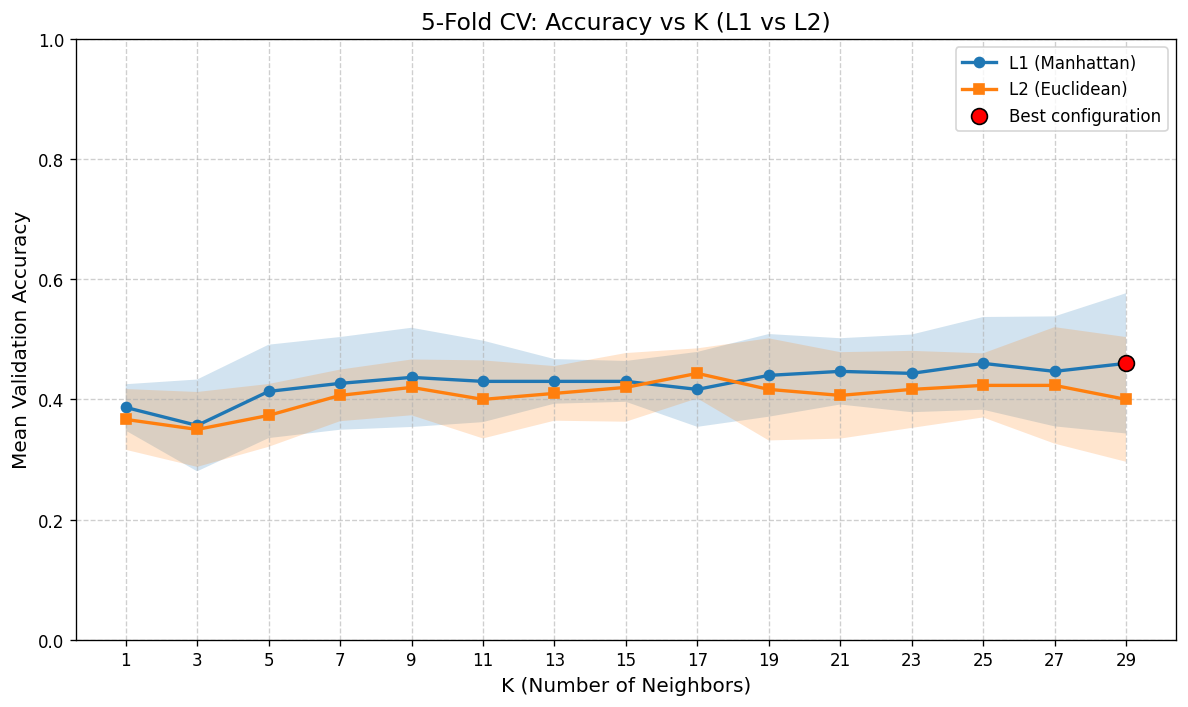

In [16]:

k_to_index = {k: i for i, k in enumerate(K_values)}
best_idx = k_to_index[best_k]
best_mean = mean_acc_l1[best_idx] if best_dist == 'l1' else mean_acc_l2[best_idx]

plt.figure(figsize=(10, 6), dpi=120)

plt.plot(K_values, mean_acc_l1, marker='o', linewidth=2, label='L1 (Manhattan)')
plt.fill_between(K_values, mean_acc_l1 - std_acc_l1, mean_acc_l1 + std_acc_l1,
                 alpha=0.2)

plt.plot(K_values, mean_acc_l2, marker='s', linewidth=2, label='L2 (Euclidean)')
plt.fill_between(K_values, mean_acc_l2 - std_acc_l2, mean_acc_l2 + std_acc_l2,
                 alpha=0.2)

plt.scatter([best_k], [best_mean], s=90, edgecolor='black',
            facecolor='red', zorder=5, label='Best configuration')

plt.title('5-Fold CV: Accuracy vs K (L1 vs L2)', fontsize=14)
plt.xlabel('K (Number of Neighbors)', fontsize=12)
plt.ylabel('Mean Validation Accuracy', fontsize=12)
plt.xticks(K_values)
plt.ylim(0, 1.0)
plt.grid(True, linestyle='--', alpha=0.6)
plt.legend(fontsize=10)
plt.tight_layout()
plt.show()


In [17]:

def stratified_train_test_split(X, y, test_ratio=0.2, seed=999):
    """
    Stratified split: keeps class proportions similar in train & test.
    """
    np.random.seed(seed)
    classes = np.unique(y)

    train_indices = []
    test_indices  = []

    for c in classes:
        class_idx = np.where(y == c)[0]
        n_c = len(class_idx)
        n_test_c = max(1, int(n_c * test_ratio))

        perm = np.random.permutation(class_idx)
        test_indices.extend(perm[:n_test_c])
        train_indices.extend(perm[n_test_c:])

    return np.array(train_indices), np.array(test_indices)


In [18]:

train_indices, test_indices = stratified_train_test_split(X, y, test_ratio=0.2, seed=999)

X_train_final = X[train_indices]
y_train_final = y[train_indices]
X_test_final  = X[test_indices]
y_test_final  = y[test_indices]

                                                
y_test_pred_final = knn_predict(
    X_train_final, y_train_final,
    X_test_final,
    k=best_k,
    distance_type=best_dist
)

num_correct = np.sum(y_test_pred_final == y_test_final)
num_total   = y_test_final.shape[0]
accuracy_percent = (num_correct / num_total) * 100.0

print(f"Using standard KNN (distance={best_dist.upper()}, K={best_k})")
print(f"Correctly predicted {num_correct} images out of {num_total}, "
      f"overall accuracy: {accuracy_percent:.1f} %")


Using standard KNN (distance=L1, K=29)
Correctly predicted 32 images out of 60, overall accuracy: 53.3 %


In [19]:

acc_unweighted = accuracy_score(y_test_final, y_test_pred_final)

y_test_pred_weighted = knn_predict_weighted(
    X_train_final, y_train_final,
    X_test_final,
    k=best_k,
    distance_type=best_dist
)
acc_weighted = accuracy_score(y_test_final, y_test_pred_weighted)

print(f"\nStandard KNN accuracy : {acc_unweighted*100:.1f} %")
print(f"Weighted KNN accuracy : {acc_weighted*100:.1f} %")

                                                      
if acc_weighted >= acc_unweighted:
    num_correct_w = np.sum(y_test_pred_weighted == y_test_final)
    print(f"\nUsing distance-weighted KNN as final model.")
    print(f"Correctly predicted {num_correct_w} images out of {num_total}, "
          f"overall accuracy: {acc_weighted*100:.1f} %")
else:
    print("\nKeeping standard KNN as final model (already reported above).")



Standard KNN accuracy : 53.3 %
Weighted KNN accuracy : 48.3 %

Keeping standard KNN as final model (already reported above).


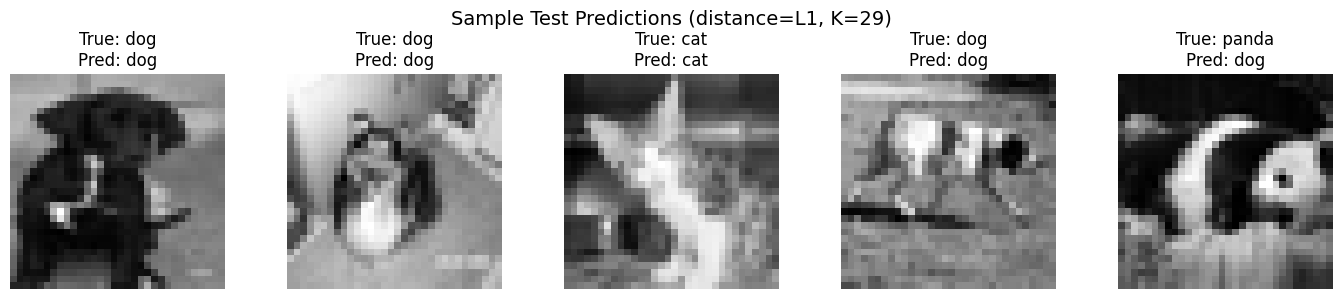

In [20]:

np.random.seed(123)
num_samples_to_show = min(5, len(test_indices))
sample_indices = np.random.choice(test_indices, size=num_samples_to_show, replace=False)

plt.figure(figsize=(14, 3))

for i, idx in enumerate(sample_indices):
    img_vec = X[idx]
    img = img_vec.reshape(IMAGE_SIZE)

    true_label = label_map[y[idx]]

                                                                     
    local_idx = np.where(test_indices == idx)[0][0]
    pred_label = label_map[y_test_pred_final[local_idx]]

    plt.subplot(1, num_samples_to_show, i + 1)
    plt.imshow(img, cmap='gray')
    plt.axis('off')
    plt.title(f"True: {true_label}\nPred: {pred_label}")

plt.suptitle(f"Sample Test Predictions (distance={best_dist.upper()}, K={best_k})",
             fontsize=14)
plt.tight_layout()
plt.show()
